In [46]:
#Importing Libraries
!pip install yellowbrick
import pandas as pd
from pandas import DataFrame
import numpy as np
from datetime import datetime
import dateutil.parser
import warnings
warnings.filterwarnings("ignore")
import os as os
os.getcwd() 
!pip install pandasql
from pandasql import sqldf
from branca.element import Figure
from matplotlib import pyplot as plt
import seaborn as sns
import numpy
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import plotly.graph_objs as go

## Part1

We have limited data on these merchants and their transactions, but we are still interested in understanding their payments activity to try to infer the types of merchants using Stripe. Using only the given data, how would you identify different kinds of businesses in the sample? Please generate assignments for each merchant.


#### Please Note that on running this NB again could result in change of cluster assignments 0,1,2 and their inference. Will upload the pdf version of this file as well for results to be consistent

### EDA

In [2]:
#importing data
data = pd.read_csv('/Users/gurri/Downloads/takehome_ds_written.csv')
#removing index
data=data.iloc[:, 1:]

In [3]:
#first 5 rows of data
data.head()

,merchant,time,amount_usd_in_cents
0,faa029c6b0,2034-06-17 23:34:14,6349
1,ed7a7d91aa,2034-12-27 00:40:38,3854
2,5608f200cf,2034-04-30 01:29:42,789
3,15b1a0d61e,2034-09-16 01:06:23,4452
4,4770051790,2034-07-22 16:21:42,20203


In [4]:
#info for data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513719 entries, 0 to 1513718
Data columns (total 3 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   merchant             1513719 non-null  object
 1   time                 1513719 non-null  object
 2   amount_usd_in_cents  1513719 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 34.6+ MB


In [5]:
#check nulls
data.isnull().sum()

merchant               0
time                   0
amount_usd_in_cents    0
dtype: int64

In [6]:
#description of data
data.describe()

,amount_usd_in_cents
count,1.513719e+06
mean,1.548466e+04
std,6.161886e+04
min,2.010000e+02
25%,3.215000e+03
50%,6.104000e+03
75%,1.260600e+04
max,2.592028e+07


In [7]:
#Count of Distinct merchants
len(set(data.merchant))

14351

In [8]:
#convert cents to $ for better intuition

data['amount_usd']=data['amount_usd_in_cents']/100
data=data.drop('amount_usd_in_cents',1)

In [9]:
# Converting timestamp columns to timestamp datatype
data['time']=pd.to_datetime(data['time'])

# function to extract time features

def extract_time_features(df):
    time_column = "time"
    df.index = pd.to_datetime(df[time_column])
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df.reset_index(drop=True)

data = extract_time_features(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513719 entries, 0 to 1513718
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   merchant    1513719 non-null  object        
 1   time        1513719 non-null  datetime64[ns]
 2   amount_usd  1513719 non-null  float64       
 3   dow         1513719 non-null  int64         
 4   hour        1513719 non-null  int64         
 5   month       1513719 non-null  int64         
 6   year        1513719 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 80.8+ MB


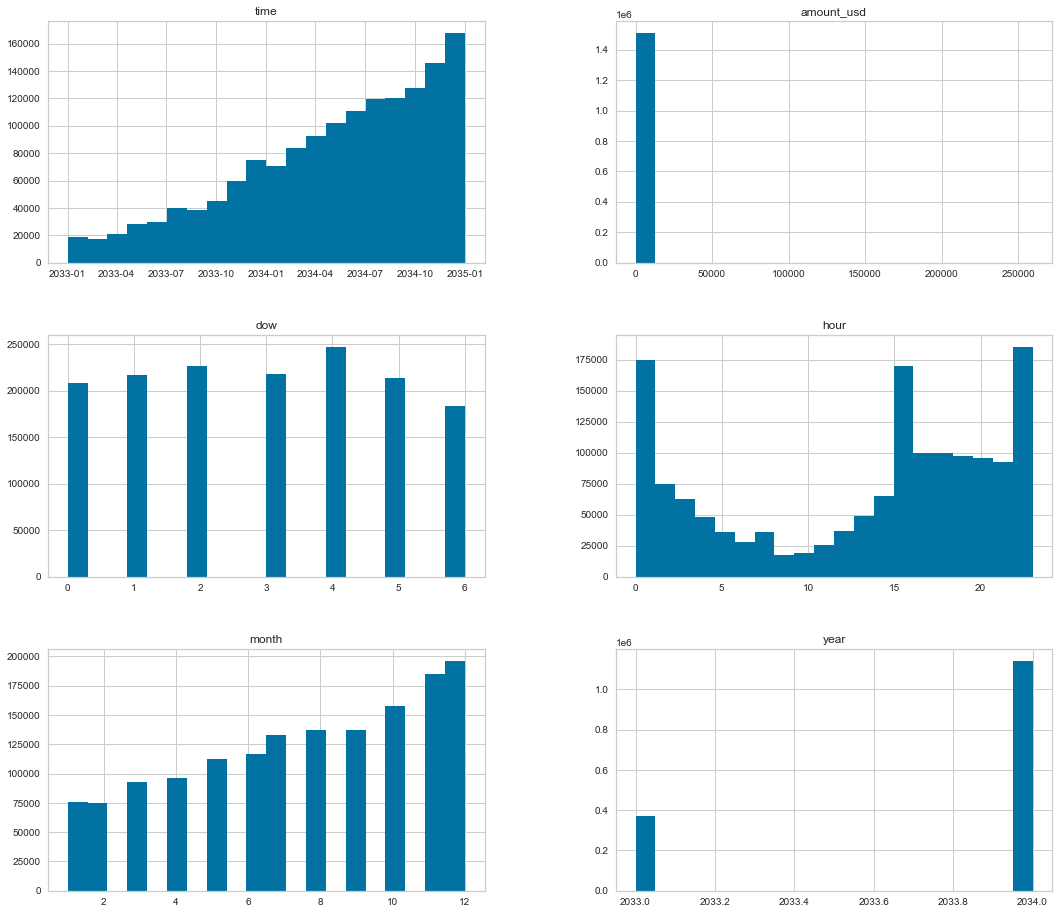

In [118]:
# histograms showing distribution of data features
data.hist(figsize=(18,16), bins=20);


Text(0.5, 0, 'Order value in $')

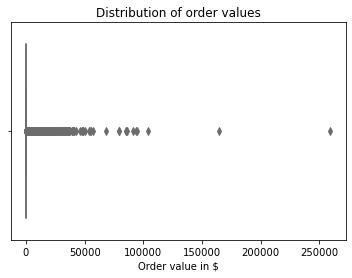

In [10]:
# Box plot showing distribution of Amount spent on orders
plot = sns.boxplot(x=data["amount_usd"], palette="husl")
plot.set_title('Distribution of order values')
plot.set_xlabel('Order value in $')

<AxesSubplot:>

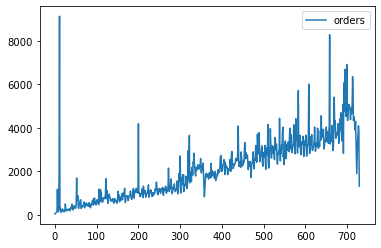

In [11]:
# No of orders over time
year_cnt=sqldf('''  select distinct date(time) as dt,count(*) as orders from
data group  by 1 order by 1''')
sns.lineplot(data=year_cnt)

In [12]:
# Repeat Customers
repeat_cust=sqldf(''' select count(merchant) as repeat_cust_count from
(select distinct merchant  from data group by 1 having 
count(distinct date(time))>1)''')
repeat_cust/14351

,repeat_cust_count
0,0.862379


In [13]:
#avg_order_gap, gap between orders placed by a merchant (in days), average the gap timings for each merchant for various orders

avg_order_gap=sqldf('''
select distinct merchant,case when avg_order_gap is null then 0 
when avg_order_gap is not null then round(avg_order_gap,0) end as avg_order_gap
from
(select distinct merchant,avg(julianday(dt)-julianday(dt2))as avg_order_gap from
(select distinct merchant,

time as dt, lag(time) over(partition by merchant order by time asc) as dt2 from data


order by 1 asc, 2 asc)
--where dt2 is not null
group by 1
)
'''
        )
avg_order_gap

,merchant,avg_order_gap
0,0002b63b92,0.0
1,0002d07bba,22.0
2,00057d4302,2.0
3,000bcff341,0.0
4,000ddbf0ca,0.0
...,...,...
14346,ffd3e45675,6.0
14347,ffe1f6b51a,5.0
14348,ffe26b900d,4.0
14349,ffec05edb9,10.0


array([[<AxesSubplot:title={'center':'avg_order_gap'}>]], dtype=object)

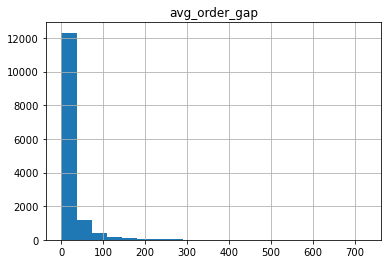

In [14]:
# Histogram for avg order gap
avg_order_gap.hist(bins=20)

In [15]:
# Spend, No of Orders and Avg Order Value for each merchant
spend_orders_aov=sqldf('''

select distinct merchant, sum(amount_usd) as spend,count(amount_usd) as orders,sum(amount_usd)/count(amount_usd) as avg_order_value
from data
group by 1



''')

spend_orders_aov

,merchant,spend,orders,avg_order_value
0,0002b63b92,33.79,1,33.790000
1,0002d07bba,892.78,4,223.195000
2,00057d4302,295.21,28,10.543214
3,000bcff341,78.26,1,78.260000
4,000ddbf0ca,102.99,1,102.990000
...,...,...,...,...
14346,ffd3e45675,726.26,5,145.252000
14347,ffe1f6b51a,2816.16,53,53.135094
14348,ffe26b900d,9591.13,81,118.409012
14349,ffec05edb9,159.34,3,53.113333


<AxesSubplot:>

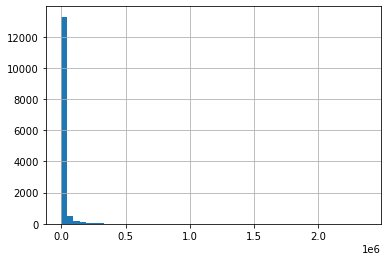

In [25]:
spend_orders_aov['spend'].hist(bins=50)


<AxesSubplot:>

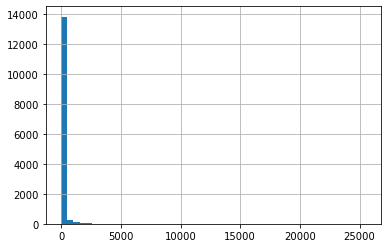

In [26]:
spend_orders_aov['orders'].hist(bins=50)

<AxesSubplot:>

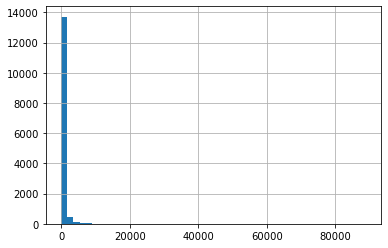

In [32]:
spend_orders_aov['avg_order_value'].hist(bins=50)

In [17]:
# Days since last order for each merchant, taking 31 Dec 2034 as the refrence point 

days_since_latest_order=sqldf('''

select distinct merchant, julianday('2034-12-31')- julianday(maxdt) as recency
from
(select distinct merchant,max(time) as maxdt
from data
group by 1)

''')
days_since_latest_order

,merchant,recency
0,0002b63b92,593.161146
1,0002d07bba,15.585891
2,00057d4302,513.814815
3,000bcff341,508.153750
4,000ddbf0ca,576.440833
...,...,...
14346,ffd3e45675,702.977431
14347,ffe1f6b51a,314.935301
14348,ffe26b900d,39.414884
14349,ffec05edb9,319.059097


array([[<AxesSubplot:title={'center':'recency'}>]], dtype=object)

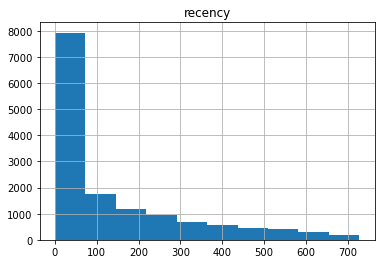

In [34]:
days_since_latest_order.hist(bins=10)

In [18]:
# Combing the above created spend, frequency and recency features to create a dataset at merchant level
cluster_data=sqldf('''
select distinct a.merchant,b.avg_order_gap,c.spend,c.orders,c.avg_order_value,round(d.recency,0)  as days_since_latest_order from data a
left join
avg_order_gap  b
on a.merchant=b.merchant
left join
spend_orders_aov c
on a.merchant=c.merchant
left join days_since_latest_order d
on a.merchant=d.merchant

''')
cluster_data

,merchant,avg_order_gap,spend,orders,avg_order_value,days_since_latest_order
0,faa029c6b0,1.0,91011.16,544,167.299926,0.0
1,ed7a7d91aa,26.0,2713.36,16,169.585000,4.0
2,5608f200cf,0.0,209115.71,25512,8.196759,0.0
3,15b1a0d61e,1.0,30038.98,521,57.656392,0.0
4,4770051790,0.0,259970.78,574,452.910767,0.0
...,...,...,...,...,...,...
14346,41f6054841,0.0,12.33,1,12.330000,295.0
14347,cce748c02b,0.0,4065.28,1,4065.280000,502.0
14348,9506efbbbd,0.0,135.36,1,135.360000,39.0
14349,7dd807a637,0.0,313.61,1,313.610000,382.0


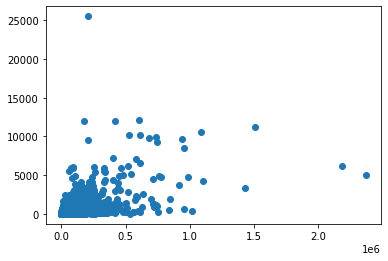

In [36]:
#Scatter Plot showing spend vs orders
x=cluster_data['spend']
y=cluster_data['orders']
plt.scatter(x, y)
plt.show()

In [39]:
# saving cluster_data in dataframe - dummy
dummy=cluster_data.iloc[:,1:6]


### Clustering - using RFM( Recency, Frequency and Monetary) Analysis and K Means

Text(0, 0.5, 'WCSS')

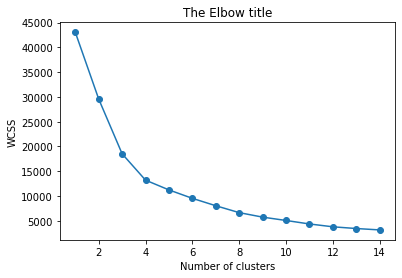

In [40]:
#Elbow method to find optimal k value for k means clustering
# Taking recency, frequency and monetary features and scaling them before using K Means

wcss=[]

sub=dummy[['spend','orders','days_since_latest_order']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sub)
for i in range(1,15):
    kmeans = KMeans(i)
    kmeans.fit(scaled_features)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,15)
plt.plot(number_clusters,wcss,marker='o')
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

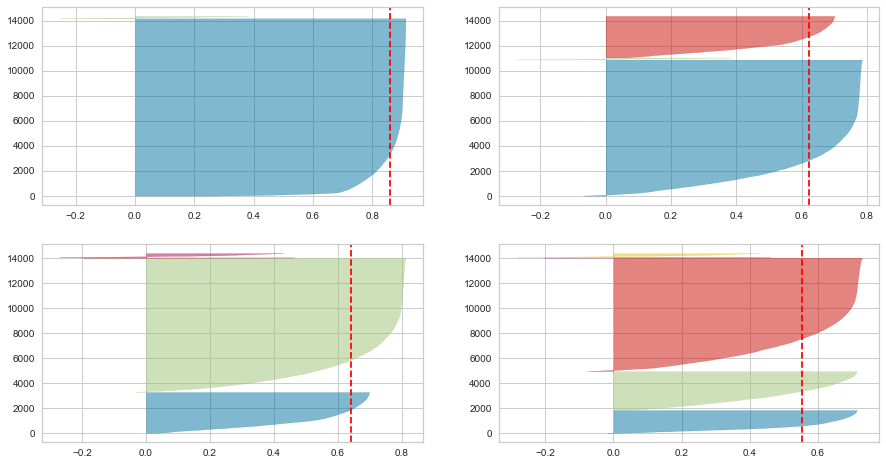

In [47]:
#Silhoutte Score Plots

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(scaled_features)

##### Based on Elbow method and Silhoutte Score Plots k=3 seems optimal no of clusters, in the above silhoutte plot,k=4 and 5 have very different cluster sizes and k=2 has just one big cluster wheareas in k=3 we can see 2 distinct clusters and one very small cluster

In [48]:
# K=3, Applying K Means clustering
kmeans = kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
cluster=kmeans.fit_predict(scaled_features)

In [49]:
print(kmeans.n_iter_)
print(kmeans.labels_)

6
[0 0 2 ... 0 1 0]


In [50]:
# adding cluster labels to data
cluster_data['cluster']=kmeans.labels_

In [51]:
#silhoutte score for k=3
score = silhouette_score(scaled_features, kmeans.labels_, metric='euclidean')
score

0.6210394485330839

In [52]:
# dataset after adding cluster labels
cluster_data.head()

,merchant,avg_order_gap,spend,orders,avg_order_value,days_since_latest_order,cluster
0,faa029c6b0,1.0,91011.16,544,167.299926,0.0,0
1,ed7a7d91aa,26.0,2713.36,16,169.585000,4.0,0
2,5608f200cf,0.0,209115.71,25512,8.196759,0.0,2
3,15b1a0d61e,1.0,30038.98,521,57.656392,0.0,0
4,4770051790,0.0,259970.78,574,452.910767,0.0,0


In [78]:
# Aggregating cluster info based on Frequency, Recency, Monetary factors

cluster_info=sqldf('''

select a.cluster,a.cnt,a.avg_consec_order_gap,a.avg_spend_per_merchant,a.aov,a.avg_days_since_latest_order,
avg_orders_per_merchant,
1.0*a.merch/b.merch as perc_merchants,
a.spend/b.tot_spend as perc_gross_revenue
from

(select distinct cluster,count(distinct merchant) as cnt,avg(avg_order_gap) as avg_consec_order_gap,

avg(spend) as avg_spend_per_merchant,
avg(orders) as avg_orders_per_merchant,
avg(avg_order_value) as aov,
avg(days_since_latest_order) as avg_days_since_latest_order ,
count(distinct merchant) as merch,
sum(spend) as spend

from
cluster_data
group by 1) a
join
(select count(distinct merchant) as merch,sum(spend) as tot_spend from cluster_data)b
on 1=1

''')
cluster_info

,cluster,cnt,avg_consec_order_gap,avg_spend_per_merchant,aov,avg_days_since_latest_order,avg_orders_per_merchant,perc_merchants,perc_gross_revenue
0,0,10870,20.748022,14229.781413,391.034497,52.905980,82.718583,0.757439,0.659904
1,1,3327,14.588819,3395.260914,324.016971,414.560265,21.936279,0.231831,0.048192
2,2,154,0.370130,444288.935065,908.043810,13.207792,3516.792208,0.010731,0.291903


##### Clusters Summary

Cluster 0 

- Has the highest no of merchants, 76% of total merchants
- Contributes to 66% of Gross Revenue
- Avg consecutive Order gap for merchant orders is the maximum around 20 days
- Avg spend per merchant is around $14000
- Avg Order value is $391
- Days since last order is around 53 days


Cluster 1 

- Has 23%% of total merchants
- Contributes to around 5% of Gross Revenue
- Avg consecutive Order gap for merchant orders is the around 14 days
- Avg spend per merchant is around $3400
- Avg Order value is $324
- Days since last order is around 414 days

Cluster 2

- Has 1% of total merchants
- Contributes to 29% of Gross Revenue
- Avg consecutive Order gap for merchant orders is the minimum less than a day
- Avg spend per merchant is around $440k
- Avg Order value is $908
- Days since last order is around 13 days

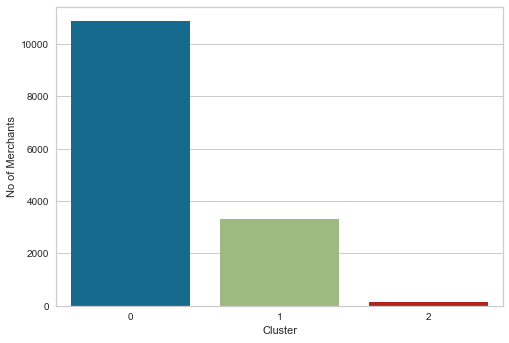

In [55]:
# Count of Merchants in each cluster

ax = sns.barplot(cluster_info['cluster'], cluster_info['cnt'])
ax.set_xlabel("Cluster")
ax.set_ylabel("No of Merchants")
plt.show()

In [56]:
# Visualizing 3 clusters based on 3d scatterplot using plotly -RFM

x=dummy[['avg_order_gap','spend','orders','days_since_latest_order']].values

Scene = dict(xaxis = dict(title  = 'Spend -->'),yaxis = dict(title  = 'Orders--->'),zaxis = dict(title  = 'Days_since_latest_order-->'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = kmeans.labels_
trace = go.Scatter3d(x=x[:, 1], y=x[:, 2], z=x[:, 3], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10),showscale=True),name = 'Cluster')
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data2 = [trace]
fig = go.Figure(data = data2, layout = layout)
fig.show()

## Part2

Sometimes a merchant may stop processing with Stripe, which we call churn. We are interested in identifying and predicting churn. Please a) come up with a concrete definition for churn b) identify merchants that have already churned in the dataset, and c) build a model to predict which active merchants are most likely to churn in the near future.

In [58]:
# importing libraries
! pip install lifetimes
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
#from lifetimes.plotting import conditional_probability_alive
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_probability_alive_matrix

In [59]:
# Converting data in the format of recency, frequency ,Monetary, Time period

summary = summary_data_from_transaction_data(data,'merchant', 'time','amount_usd',observation_period_end='2034-12-31')

In [60]:
summary.head()

,frequency,recency,T,monetary_value
merchant,,,,
0002b63b92,0.0,0.0,594.0,0.000000
0002d07bba,3.0,65.0,81.0,279.096667
00057d4302,1.0,66.0,580.0,91.350000
000bcff341,0.0,0.0,509.0,0.000000
000ddbf0ca,0.0,0.0,577.0,0.000000


In [61]:
# Fitting Model Beta Geo Fitter

bgf = BetaGeoFitter()
bgf.fit(summary['frequency'], summary['recency'], summary['T'],summary['monetary_value'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 14351 subjects, a: 0.15, alpha: 4.41, b: 1.16, r: 0.68>


In [62]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.681746,0.000352,0.681056,0.682437
alpha,4.409194,0.003425,4.402482,4.415906
a,0.148030,0.000171,0.147695,0.148365
b,1.162020,0.002254,1.157601,1.166439


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

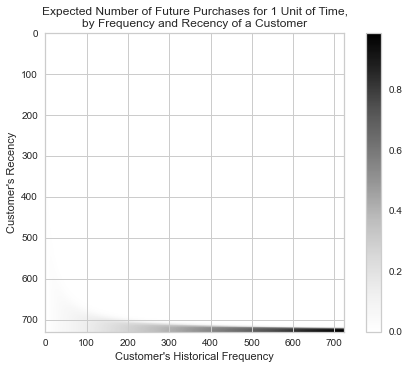

In [63]:
# Plotting Frequency and recency
plot_frequency_recency_matrix(bgf)

In [64]:
# Original Data set, changing timestamp to days
dataset=sqldf(''' select merchant,date(time) as time ,amount_usd from data''')
dataset.head(5)

,merchant,time,amount_usd
0,faa029c6b0,2034-06-17,63.49
1,ed7a7d91aa,2034-12-27,38.54
2,5608f200cf,2034-04-30,7.89
3,15b1a0d61e,2034-09-16,44.52
4,4770051790,2034-07-22,202.03


In [65]:
# Adding probability of being alive based on RFM 
# Churn Probability = 1-Probability of being alive

summary['probability_alive']=bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])

In [66]:
summary

,frequency,recency,T,monetary_value,probability_alive
merchant,,,,,
0002b63b92,0.0,0.0,594.0,0.000000,1.000000e+00
0002d07bba,3.0,65.0,81.0,279.096667,9.086972e-01
00057d4302,1.0,66.0,580.0,91.350000,1.826430e-01
000bcff341,0.0,0.0,509.0,0.000000,1.000000e+00
000ddbf0ca,0.0,0.0,577.0,0.000000,1.000000e+00
...,...,...,...,...,...
ffd3e45675,4.0,23.0,726.0,139.997500,5.947391e-06
ffe1f6b51a,46.0,260.0,575.0,60.193478,3.881966e-14
ffe26b900d,65.0,334.0,374.0,143.492154,2.225668e-01


In [67]:
# Output data with probability of being alive as of current date i.e 31 Dec 2034
# Removing the merchants who placed just one order from our analysis

out=sqldf('''

select * from summary where probability_alive!=1 and frequency!=0 and recency!=0''')

out



,merchant,frequency,recency,T,monetary_value,probability_alive
0,0002d07bba,3.0,65.0,81.0,279.096667,9.086972e-01
1,00057d4302,1.0,66.0,580.0,91.350000,1.826430e-01
2,000ed1585f,57.0,656.0,681.0,283.450702,9.783949e-01
3,000f8c3297,147.0,457.0,458.0,233.489932,9.986171e-01
4,0020aefbd9,1.0,23.0,215.0,94.150000,1.919121e-01
...,...,...,...,...,...,...
12371,ffd3e45675,4.0,23.0,726.0,139.997500,5.947391e-06
12372,ffe1f6b51a,46.0,260.0,575.0,60.193478,3.881966e-14
12373,ffe26b900d,65.0,334.0,374.0,143.492154,2.225668e-01
12374,ffec05edb9,2.0,20.0,340.0,53.580000,1.192817e-02


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

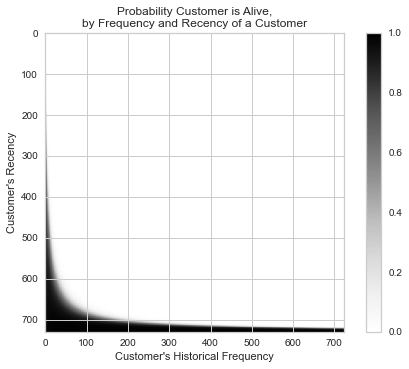

In [68]:
# plotting probability customer is alive based on Recency and Frequency
plot_probability_alive_matrix(bgf)

In [69]:
# Count of merchants with probabilty of being alive 
p=sqldf('''select distinct round(probability_alive,1)  as prob_alive, count(distinct merchant) as cnt 
from summary 
where probability_alive !=1 and frequency!=0 and recency!=0
group by 1 order by 1 asc''')
p


,prob_alive,cnt
0,0.0,3021
1,0.1,581
2,0.2,356
3,0.3,279
4,0.4,268
5,0.5,247
6,0.6,312
7,0.7,424
8,0.8,716
9,0.9,1614


<AxesSubplot:xlabel='prob_alive', ylabel='cnt'>

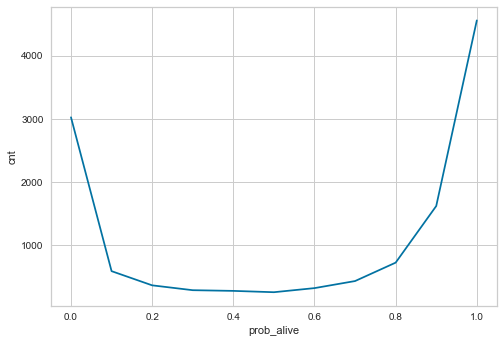

In [145]:
# Line Plot showing Probability of being alive at end of time period 31 dec 2034
sns.lineplot(x=p['prob_alive'],y=p['cnt'])

In [70]:
#evaluating model on hold out

summary_cal_holdout = calibration_and_holdout_data(dataset, 'merchant', 'time',calibration_period_end='2034-09-01',
observation_period_end='2034-12-31')
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
merchant                                                           
0002b63b92            0.0          0.0  473.0                0.0   
00057d4302            1.0         66.0  459.0                0.0   
000bcff341            0.0          0.0  388.0                0.0   
000ddbf0ca            0.0          0.0  456.0                0.0   
000ed1585f           55.0        549.0  560.0                2.0   

            duration_holdout  
merchant                      
0002b63b92             121.0  
00057d4302             121.0  
000bcff341             121.0  
000ddbf0ca             121.0  
000ed1585f             121.0  


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

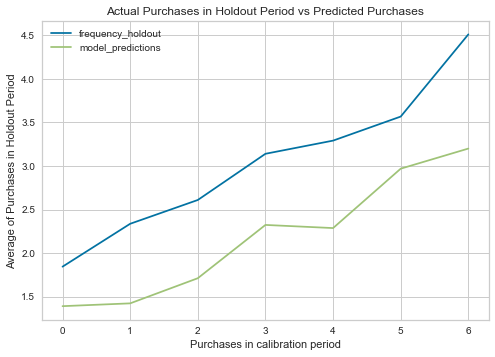

In [71]:
# Plot of predcited vs Actual Purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'],summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

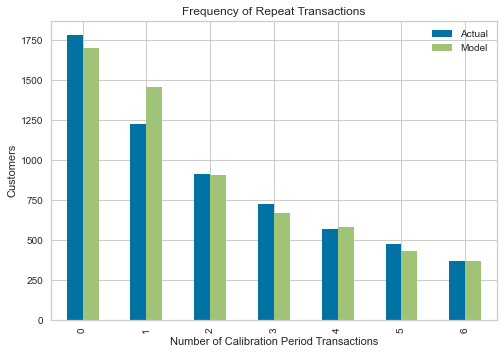

In [72]:
# Actual vs Predicted Frequency of repeat transactions
plot_period_transactions(bgf)

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

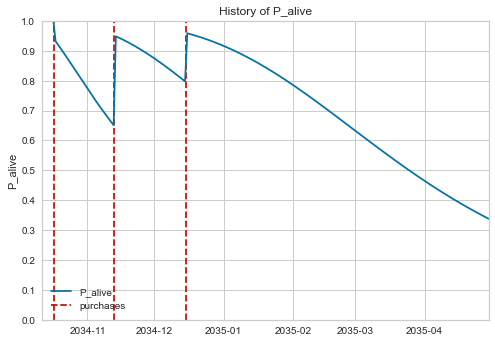

In [73]:
# For a Merchant, history of Probability of being alive throughout his journey
    
id = '0002d07bba'
days_since_birth = 200
sp_trans = data.loc[data['merchant'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans,'time')


##### Already Churned Merchants

Merchants with current probability of being alive =0, based on the model

In [74]:
#Already Churned
churned=sqldf('select sum(cnt) as count_churned from p where prob_alive=0')
print(churned[0:1])
print('% Churned' ,churned/len(out))

   count_churned
0           3021
% Churned    count_churned
0       0.244101


##### Active Merchants Likely to be Churned

Merchants with current probability of being alive greater than 0 and less than 0.5, based on the model

In [76]:
##Likely to churn
likely_to_churn=sqldf('select sum(cnt) as count_likely_to_churn from p where prob_alive between 0.1 and 0.5')
print(likely_to_churn[0:1])
print('% Active Merchants currently likely to churn: '+ str(1731.0/9855))

   count_likely_to_churn
0                   1731
% Active Merchants currently likely to churn: 0.1756468797564688


In [77]:
# Final dataset with merchnat churn flags and likely to churn flags

final_out=sqldf('''select * ,case when round(probability_alive,1) =0 then 1 else 0 end as current_churn_status,
case when round(probability_alive,1) between 0.1 and 0.5 and round(probability_alive,1)!=0 then 1 
when round(probability_alive,1) >0.5 and round(probability_alive,1)!=0 then 0 
when round(probability_alive,1)=0 then 'already_churned' end as likely_to_churn
from out ''')
final_out


,merchant,frequency,recency,T,monetary_value,probability_alive,current_churn_status,likely_to_churn
0,0002d07bba,3.0,65.0,81.0,279.096667,9.086972e-01,0,0
1,00057d4302,1.0,66.0,580.0,91.350000,1.826430e-01,0,1
2,000ed1585f,57.0,656.0,681.0,283.450702,9.783949e-01,0,0
3,000f8c3297,147.0,457.0,458.0,233.489932,9.986171e-01,0,0
4,0020aefbd9,1.0,23.0,215.0,94.150000,1.919121e-01,0,1
...,...,...,...,...,...,...,...,...
12371,ffd3e45675,4.0,23.0,726.0,139.997500,5.947391e-06,1,already_churned
12372,ffe1f6b51a,46.0,260.0,575.0,60.193478,3.881966e-14,1,already_churned
12373,ffe26b900d,65.0,334.0,374.0,143.492154,2.225668e-01,0,1
12374,ffec05edb9,2.0,20.0,340.0,53.580000,1.192817e-02,1,already_churned
